In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.metrics import R2Score
import yfinance as yf

/root/cryptobot-enviroment/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2025-01-01 15:16:40.711326: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 15:16:40.842640: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-01 15:16:41.032756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735755401.199591   20213 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plu

In [5]:

def read_invest_com_crypto_data(ticker_name):
    try:
        # Read the CSV file
        ticker = yf.Ticker(ticker_name)
        df = ticker.history(period="max", interval="1d")
        print(df.head())

        # Set the timestamp as the index
        return df.loc[:, ~df.columns.isin(["Volume", "Dividends", "Stock Splits"])]
    
    except FileNotFoundError:
        print("Error: The specified CSV file was not found.")
        return None
    
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
        return None
    
    except pd.errors.ParserError:
        print("Error: An error occurred while parsing the CSV file.")
        return None

In [58]:
# Fetch Ripple price data
df = read_invest_com_crypto_data("XRP-USD")
dataCutoff = int(len(df) * 0.3)
print("Cutoff: ", dataCutoff)

train_date_series = df.index[:-dataCutoff]
test_date_series = df.index[-dataCutoff:]

train_data = df["Close"][:-dataCutoff].values.reshape(-1, 1)
testData = df["Close"][-dataCutoff:].values.reshape(-1, 1)

print(f"Train Data: {train_data.shape}\nTest Data: {testData.shape}")

train_target = train_data
test_target = testData
print(f"Train Target: {train_target.shape}\nTest Data: {test_target.shape}")

                               Open      High       Low     Close     Volume  \
Date                                                                           
2017-11-09 00:00:00+00:00  0.217911  0.221791  0.214866  0.217488  147916992   
2017-11-10 00:00:00+00:00  0.218256  0.219068  0.205260  0.206483  141032992   
2017-11-11 00:00:00+00:00  0.205948  0.214456  0.205459  0.210430  134503008   
2017-11-12 00:00:00+00:00  0.210214  0.210214  0.195389  0.197339  251175008   
2017-11-13 00:00:00+00:00  0.197472  0.204081  0.197456  0.203442  132567000   

                           Dividends  Stock Splits  
Date                                                
2017-11-09 00:00:00+00:00        0.0           0.0  
2017-11-10 00:00:00+00:00        0.0           0.0  
2017-11-11 00:00:00+00:00        0.0           0.0  
2017-11-12 00:00:00+00:00        0.0           0.0  
2017-11-13 00:00:00+00:00        0.0           0.0  
Cutoff:  783
Train Data: (1828, 1)
Test Data: (783, 1)
Train Target:

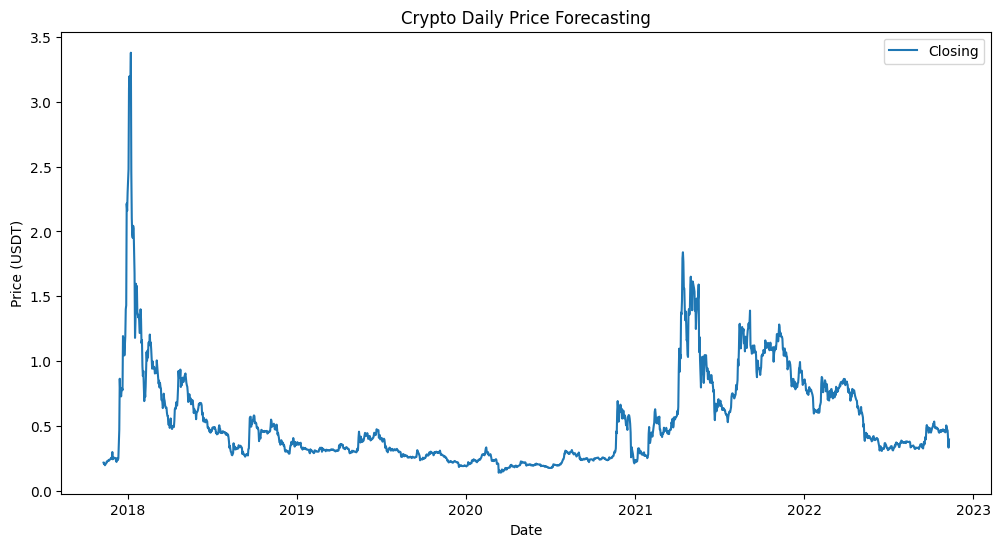

In [59]:
# Plot train data
plt.figure(figsize=(12, 6))
plt.plot(train_date_series, train_data, label='Closing')
plt.title('Crypto Daily Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

### Normalization
- Scales the input data between (0, 1)
- I think MinMax only can be used also
- it's important to keep the scaling parameters!

In [60]:
# Normalize the data
scaler = RobustScaler()
normalized_data = scaler.fit_transform(train_data)
print(normalized_data.shape)


(1828, 1)


In [61]:
normalized_data

array([[-0.43257239],
       [-0.45923118],
       [-0.44966989],
       ...,
       [ 0.02466999],
       [-0.15231484],
       [-0.0008551 ]])

In [62]:
# Function to prepare data for LSTM
def prepare_data(normalized_data, target, data, seq_len):
    X, y = [], []
    for i in range(len(normalized_data) - seq_len):
        X.append(normalized_data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y), data[:-seq_len]


In [63]:
# Prepare data for each EWT component
seq_len = 90  # 24 hours for daily predictions
X, y, train_data = prepare_data(normalized_data, train_target, train_data, seq_len)

y = y.reshape(-1, 1)
train_date_series= train_date_series[:-seq_len]
print(y.shape, X.shape, train_date_series.shape)

(1738, 1) (1738, 90, 1) (1738,)


In [64]:
# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [ ]:
# Train separate LSTM models for each EWT component
model = create_lstm_model((seq_len, 1))
model.fit(X, y, epochs=100, verbose=2 )


Epoch 1/100
55/55 - 9s - 169ms/step - loss: 0.0370
Epoch 2/100
55/55 - 7s - 126ms/step - loss: 0.0062
Epoch 3/100
55/55 - 6s - 107ms/step - loss: 0.0055
Epoch 4/100


In [31]:
# Make predictions
predictions = np.zeros_like(y)
for i in range(seq_len, len(y)):
    print(i)
    inputs = normalized_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    predictions[i] = pred


24
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
(1, 1)
25
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(1, 1)
26
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(1, 1)
27
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(1, 1)
28
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
(1, 1)
29
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(1, 1)
30
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(1, 1)
31
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(1, 1)
32
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
(1, 1)
33
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1)
34
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(1, 1)
35
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1, 1)
36
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(1, 1)
37
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(1, 1)
38
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1)
39
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1, 1)
40
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(1, 1)
41
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/ste

In [32]:
print(train_date_series.shape, train_data.shape, predictions.shape)

(2608,) (2608, 1) (2608, 1)


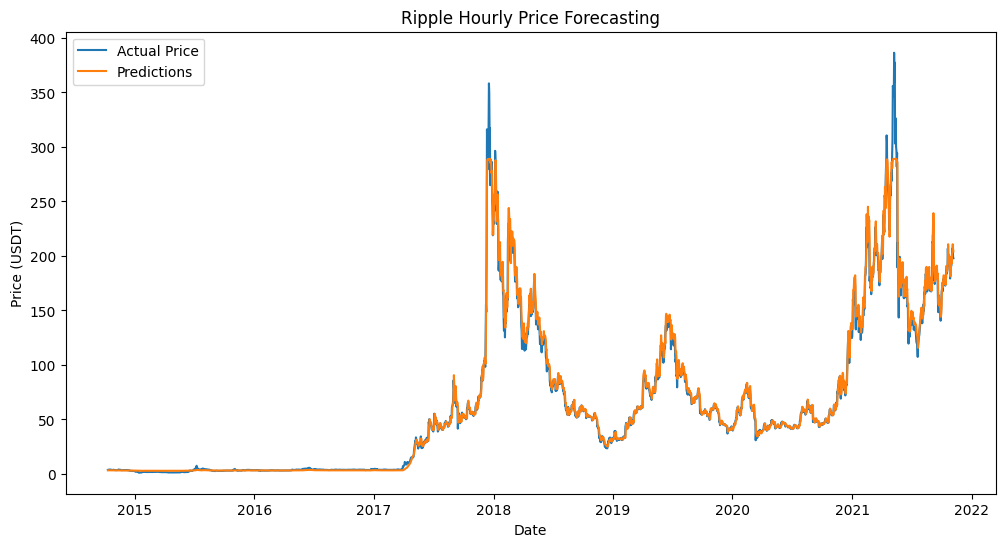

In [33]:
reshaped = predictions.reshape(-1, 1)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(train_date_series[seq_len:], train_data[seq_len:], label='Actual Price')
plt.plot(train_date_series[seq_len:], reshaped[seq_len:], label='Predictions')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()


In [34]:
# Evaluate the model
mse = np.mean((train_data[seq_len:] - reshaped[seq_len:]) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(train_data[seq_len:] - reshaped[seq_len:]))
mape = np.mean(np.abs((train_data[seq_len:] - reshaped[seq_len:]) / train_data[seq_len:])) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 7.3402
MAE: 3.2880
MAPE: 11.3463


In [35]:
normalized_test_data = scaler.transform(testData)
X_test, y_test, testData = prepare_data(normalized_test_data, test_target, testData, seq_len)
y_test = y_test.reshape(-1, 1)
y_test.shape
print(testData.shape)

(1104, 1)


In [36]:
model.evaluate(X_test, y_test, verbose=2)

35/35 - 1s - 21ms/step - loss: 18.9909


18.990930557250977

In [52]:
# Make test predictions
test_predictions = np.zeros_like(y_test)
for i in range(len(y_test)-2, len(y_test)):
    print(i)
    inputs = normalized_test_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    test_predictions[i] = pred

(1128, 1)
1102
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
(1, 1)
1103
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1)


(1128,) (1104, 1) (1104, 1)


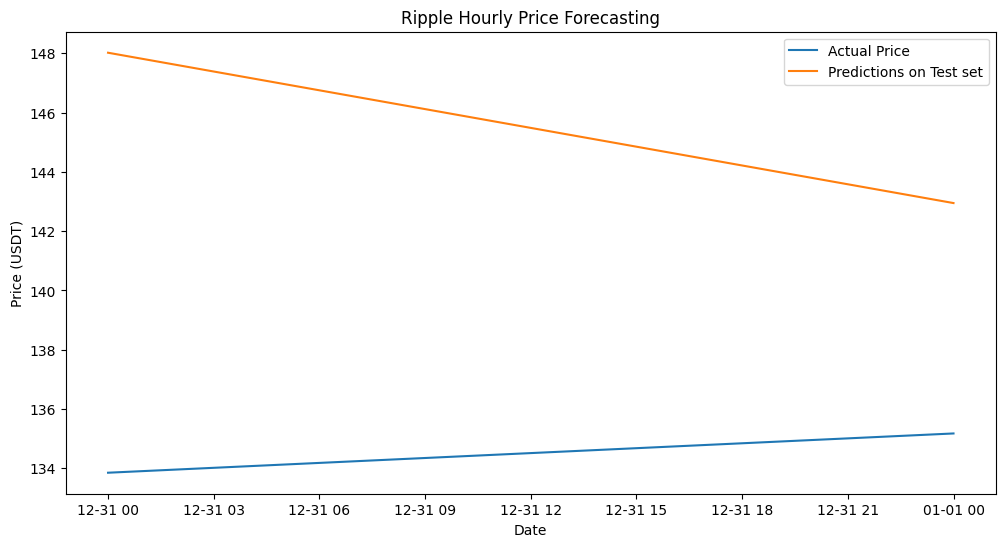

In [ ]:
test_reshaped = test_predictions.reshape(-1, 1)
print(test_date_series.shape, testData.shape, test_reshaped.shape)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(test_date_series[-2:], testData[-2:], label='Actual Price')
plt.plot(test_date_series[-2:], test_reshaped[-2:], label='Predictions on Test set')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model 
r2 = R2Score()
testDataToUse = testData[-2:]
testPredictionsToUse = test_reshaped[-2:]
print(testDataToUse.shape, testPredictionsToUse.shape)

r2.update_state(testDataToUse, testPredictionsToUse)
r2.result().numpy()

mse = np.mean((testDataToUse - testPredictionsToUse) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(testDataToUse - testPredictionsToUse))
mape = np.mean(np.abs((testDataToUse - testPredictionsToUse) / testDataToUse)) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"accuracy: {r2.result().numpy()}")

(2, 1) (2, 1)
RMSE: 11.4293
MAE: 10.9725
MAPE: 8.1692
accuracy: -296.2523193359375
